In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

pd.options.display.max_rows = 100

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("trn.csv")
tst = pd.read_csv("tst.csv")
tr = pd.read_csv("tr.csv")
tps = pd.read_csv("tr_types.csv", sep=";")
cds = pd.read_csv("tr_cds.csv", sep=";")

In [4]:
print(df.shape)
df.head()

(8400, 2)


,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1


In [5]:
print(tr.shape)
tr.head()

(6849346, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [6]:
df = tr.merge(df, on="customer_id", how="outer")

In [7]:
df = df.drop(["term_id"], axis=1)

In [8]:
# gender:NaN => rows from test
df.sample(10)

,customer_id,tr_datetime,mcc_code,tr_type,amount,gender
2015617,26147466,422 16:11:58,5712,1110,-10241.38,NaN
2430484,83275391,302 00:00:00,5411,1110,-2964.61,0.0
1710869,14076810,244 14:56:01,6011,7011,1572141.04,1.0
4131892,38691781,12 19:31:27,6010,7070,4446.91,NaN
46550,6443703,427 10:13:12,6011,2010,-67377.47,0.0
875348,32489134,172 23:55:58,6010,7071,224.59,NaN
913822,22882838,433 00:00:00,5411,1110,-46243.41,1.0
5543757,61116638,159 12:53:28,5331,1010,-8826.45,0.0
4101584,8495915,10 17:29:35,6011,7011,112295.79,NaN
956723,60428201,245 12:33:01,6011,2010,-89836.63,0.0


# Feature engineering

## Frequency (independently of datetime)

In [9]:
#Idea: estimate frequency of MCC and TR_TYPE occurance depending on gender

In [10]:
def frequencies_ratio(df, key_column):
    def get_frequencies(gender):
        return (
            df[df.gender == gender][["gender", key_column]].groupby(key_column).count()
        )

    frequencies = get_frequencies(gender=1).sort_values(by="gender", ascending=False)
    frequencies = frequencies.merge(get_frequencies(gender=0), on=key_column)
    c = df[df.gender == 0].shape[0] / df[df.gender == 1].shape[0]
    frequencies[key_column + "_1to0_ratio"] = (
        c * frequencies.gender_x / frequencies.gender_y
    ).round(3)
    return frequencies.drop(["gender_x", "gender_y"], axis=1)

In [11]:
df = df.merge(frequencies_ratio(df, "mcc_code"), on="mcc_code", how="outer")
df = df.merge(frequencies_ratio(df, "tr_type"), on="tr_type", how="outer")

In [12]:
# hardcode (better to rewrite)


def frequencies2(df):
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio > 2].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_r2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio < 0.5].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_l2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio > 2].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_r2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio < 0.5].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_l2"]
    df = df.merge(tmp, on="customer_id", how="outer")
    return df


def frequencies3(df):
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio > 3].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_r3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.mcc_code_1to0_ratio < 0.333].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["mcc_l3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio > 3].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_r3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    tmp = pd.DataFrame(
        df[df.tr_type_1to0_ratio < 0.333].groupby("customer_id").count()["mcc_code"]
    )
    tmp.columns = ["trt_l3"]
    df = df.merge(tmp, on="customer_id", how="outer")
    return df

In [13]:
df = frequencies2(df)
df = frequencies3(df)

In [14]:
df = df.fillna({"mcc_r2": 1, "mcc_l2": 1, "trt_r2": 1, "trt_l2": 1})  # to prevent /0
df = df.fillna({"mcc_r3": 1, "mcc_l3": 1, "trt_r3": 1, "trt_l3": 1})  # to prevent /0

In [15]:
def preprocessing_ratios(df):
    def helper(x):
        a = x[0]
        b = x[1]
        ratio = a / b
        if (a < 5) & (b < 5):
            return 0
        elif ratio > 1:
            return ratio
        else:
            return -1.0 / ratio

    df["mcc2_factor"] = df[["mcc_r2", "mcc_l2"]].apply(helper, axis=1).round(3)
    df["trt2_factor"] = df[["trt_r2", "trt_l2"]].apply(helper, axis=1).round(3)
    return df

In [16]:
%%time
df = preprocessing_ratios(df)

CPU times: user 4min 24s, sys: 781 ms, total: 4min 24s
Wall time: 4min 24s


## Time features

In [17]:
def time_preprocessing(df):
    df["day"], df["time"] = df.tr_datetime.str.split(" ", 1).str
    df.time = pd.to_datetime(df.time, format="%H:%M:%S")
    df["hour"] = df.time.dt.round("H").dt.hour
    df.day = df.day.astype("int")

    # to prevent difference between 23 and 01
    k = 2 * np.pi / 24
    df["sin_hour"] = df["hour"].map(lambda x: np.sin(x * k))
    df["cos_hour"] = df["hour"].map(lambda x: np.cos(x * k))
    df.drop(["tr_datetime", "time"], axis=1, inplace=True)
    return df

In [18]:
df = time_preprocessing(df)

In [19]:
df.sample(20)

,customer_id,mcc_code,tr_type,amount,gender,mcc_code_1to0_ratio,tr_type_1to0_ratio,mcc_r2,mcc_l2,trt_r2,...,mcc_r3,mcc_l3,trt_r3,trt_l3,mcc2_factor,trt2_factor,day,hour,sin_hour,cos_hour
2335027,77981085,5499,1010,-6580.53,1.0,0.986,0.975,47.0,4.0,1.0,...,17.0,1.0,1.0,1.0,11.750,0.0,330,11,2.588190e-01,-9.659258e-01
735281,86370215,5311,1010,-3471.06,NaN,0.867,0.975,50.0,11.0,1.0,...,37.0,10.0,1.0,1.0,4.545,0.0,232,12,1.224647e-16,-1.000000e+00
5229770,87094958,5411,1110,-4556.96,NaN,0.959,1.167,21.0,8.0,1.0,...,14.0,1.0,1.0,1.0,2.625,0.0,274,15,-7.071068e-01,-7.071068e-01
5654223,50446331,5921,1010,-1909.03,0.0,1.781,0.975,17.0,18.0,1.0,...,2.0,5.0,1.0,1.0,-1.059,0.0,415,10,5.000000e-01,-8.660254e-01
2556506,90796706,6010,7070,11229.58,NaN,0.980,0.989,1.0,11.0,1.0,...,1.0,7.0,1.0,1.0,-11.000,0.0,352,5,9.659258e-01,2.588190e-01
3673901,52161579,6011,7010,2245.92,1.0,1.028,0.956,54.0,1.0,1.0,...,39.0,1.0,1.0,1.0,54.000,0.0,140,9,7.071068e-01,-7.071068e-01
3014880,56687390,6011,2010,-22459.16,0.0,1.028,1.009,1.0,4.0,1.0,...,1.0,1.0,1.0,1.0,0.000,0.0,124,20,-8.660254e-01,5.000000e-01
5423883,54281801,6011,2010,-15721.41,NaN,1.028,1.009,7.0,6.0,1.0,...,2.0,1.0,1.0,1.0,1.167,0.0,268,15,-7.071068e-01,-7.071068e-01
6761663,70780820,6010,7070,4828.72,1.0,0.980,0.989,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.000,0.0,109,11,2.588190e-01,-9.659258e-01
1444049,32990734,5999,1010,-2650.18,0.0,1.020,0.975,94.0,37.0,1.0,...,54.0,11.0,1.0,1.0,2.541,0.0,279,17,-9.659258e-01,-2.588190e-01


In [20]:
# aggregate->predict or predict->aggregate?

# Train

In [21]:
#([predict]->[aggregate by mean] case)

In [22]:
#hyperopt?
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.02,
    "num_leaves": 80,
    "feature_fraction": 0.64,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "boosting_type": "gbdt",
}

In [23]:
def prepare_sample(df):
    df = df.dropna()
    X = df.drop(["gender", "customer_id"], axis=1, errors="ignore")
    y = df.gender
    return X, y

In [24]:
X_train, y_train = prepare_sample(df)

In [25]:
%%time
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
# model = lgb.train(params, dtrain, verbose_eval=50)

CPU times: user 1min 41s, sys: 909 ms, total: 1min 42s
Wall time: 8.31 s


# Results

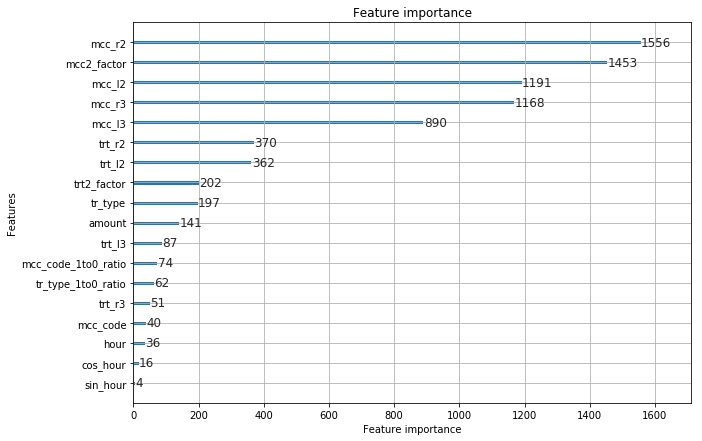

In [26]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.set(style="darkgrid")
lgb.plot_importance(model, ax=ax)

In [27]:
df_train = df.dropna()
df_train["gender_pred"] = model.predict_proba(X_train)[:, 1]

In [28]:
df_test = df.merge(tst, on="customer_id", how="inner")
X_test = df_test.drop(["gender", "customer_id", "probability"], axis=1, errors="ignore")
df_test["gender_pred"] = model.predict_proba(X_test)[:, 1]

In [35]:
# heuristic
def postprocessing(df):
    def helper(x):
        pred = x[0]
        mcc = x[1]
        trt = x[2]
        if mcc + trt > 10:
            return 1.0
        elif mcc + trt < -10:
            return 0.0
        else:
            return pred

    df["gender_pred_2"] = (
        df[["gender_pred", "mcc2_factor", "trt2_factor"]].apply(helper, axis=1).round(3)
    )
    return df

In [36]:
%%time
df_train = postprocessing(df_train)
df_test = postprocessing(df_test)

CPU times: user 2min 22s, sys: 390 ms, total: 2min 23s
Wall time: 2min 23s


In [37]:
df_train.sample(10)

,customer_id,mcc_code,tr_type,amount,gender,mcc_code_1to0_ratio,tr_type_1to0_ratio,mcc_r2,mcc_l2,trt_r2,...,trt_r3,trt_l3,mcc2_factor,trt2_factor,day,hour,sin_hour,cos_hour,gender_pred,gender_pred_2
3107211,29453966,6011,2010,-449183.15,1.0,1.028,1.009,1.0,1.0,1.0,...,1.0,1.0,0.000,0.0,354,13,-0.258819,-9.659258e-01,0.448431,0.448
4467281,38223980,6011,7010,89836.63,0.0,1.028,0.956,34.0,165.0,1.0,...,1.0,1.0,-4.853,0.0,44,19,-0.965926,2.588190e-01,0.150033,0.150
6576559,46011296,6011,2010,-4491.83,1.0,1.028,1.009,21.0,9.0,1.0,...,1.0,1.0,2.333,0.0,146,13,-0.258819,-9.659258e-01,0.602609,0.603
6609564,13360507,6011,2010,-258280.31,0.0,1.028,1.009,13.0,1.0,1.0,...,1.0,1.0,13.000,0.0,322,11,0.258819,-9.659258e-01,0.676774,1.000
5182187,60469603,4814,1030,-2245.92,0.0,0.817,0.812,34.0,23.0,1.0,...,1.0,1.0,1.478,0.0,329,16,-0.866025,-5.000000e-01,0.335859,0.336
4418072,21785327,4814,1030,-11229.58,0.0,0.817,0.812,1.0,14.0,1.0,...,1.0,1.0,-14.000,0.0,340,20,-0.866025,5.000000e-01,0.158179,0.000
4818271,73117800,6010,7031,224591.58,1.0,0.980,1.087,4.0,23.0,1.0,...,1.0,1.0,-5.750,0.0,259,18,-1.000000,-1.836970e-16,0.183883,0.184
350522,69197914,6010,7070,49410.15,0.0,0.980,0.989,8.0,4.0,10.0,...,1.0,1.0,2.000,5.0,205,18,-1.000000,-1.836970e-16,0.301318,0.301
5199140,84954803,5499,1010,-33374.31,1.0,0.986,0.975,207.0,25.0,1.0,...,1.0,1.0,8.280,0.0,1,21,-0.707107,7.071068e-01,0.880102,0.880
1767904,54161169,4814,1100,-4491.83,0.0,0.817,1.265,8.0,8.0,1.0,...,1.0,1.0,-1.000,0.0,200,0,0.000000,1.000000e+00,0.427674,0.428


In [38]:
roc_auc_score(df_train.gender, df_train.gender_pred) #train roc-auc before aggregation by transactions

0.9283968518352546

In [39]:
trn_pred = df_train.groupby("customer_id")["gender_pred", "gender_pred_2"].mean()
tst_pred = df_test.groupby("customer_id")["gender_pred", "gender_pred_2"].mean()

In [40]:
abc = pd.read_csv('trn.csv')
abc = abc.merge(trn_pred, on='customer_id')
print(roc_auc_score(abc.gender, abc.gender_pred)) #no postprocessing (roc-auc after aggregation)
print(roc_auc_score(abc.gender, abc.gender_pred_2)) #with postprocessing (roc-auc after aggregation))

0.8598601285043797
0.8468493718062307


In [41]:
tst = pd.read_csv('tst.csv')
tst = tst.merge(tst_pred, on='customer_id')
tst = tst.drop('probability', axis=1)

In [42]:
tst = tst.rename(columns={'gender_pred':'probability'})
#tst = tst.rename(columns={'gender_prediction_2':'probability'})
tst.drop('gender_pred_2', axis=1).to_csv('pred1.csv', index=False)
#tst.drop('gender_pred', axis=1).to_csv('pred2.csv', index=False)

In [43]:
#kaggle public lb score: 0.79254 //nickname: customname

In [44]:
#potential improvements:

#hyperopt/gridsearch for parameters on cross-validation
#consider datetime effect (e.g. probably men make transactions after working hours more often)
#better postproccessing
#outliers
#exclude popular transactions/MCCs focusing on 'special'
#term_id feature (?)
#Pre-Feb.23 & pre-Mar. 8 (?)
#Logit/RF/XGB/CTB (?)